# Corruption Robustness Analysis: Mirror Descent vs SGD

This notebook analyzes how Mirror Descent (MD) and SGD handle different types of corruption:
- **Identity**: Standard MD (no corruption)
- **Block-Diagonal**: Structured corruption
- **Full-Dense**: Complete corruption

Dataset: `decouple-alphas-grid`

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wandb import Api
import warnings
import json
warnings.filterwarnings('ignore')

In [2]:
# Setup plotting style for publication
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'sans-serif',
    'axes.linewidth': 2,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'figure.dpi': 150,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Define colors - biological inspiration
colors = {
    'SGD': '#2E86AB',    # Ocean blue - traditional/stable
    'MD': '#A23B72',     # Neural pink - adaptive/biological
    'identity': '#E8F4F8',      # Light blue background
    'block_diagonal': '#F0E68C', # Highlighted yellow background
    'full_dense': '#FFE4E1'      # Light red background
}

In [3]:
# Load corruption dataset
api = Api(timeout=120)
ENTITY = "hp-learning-rules"

def load_corruption_data():
    """Load corruption experiment data from WandB"""
    runs = api.runs(f"{ENTITY}/decouple-alphas-grid", filters={"state": "finished"})
    
    data = []
    for run in runs:
        row = {'run_id': run.id, 'name': run.name}
        
        # Add all config and summary data
        if run.config:
            # Flatten nested config if needed
            config_flat = {}
            for key, value in run.config.items():
                if isinstance(value, dict):
                    for subkey, subvalue in value.items():
                        config_flat[f'config_{key}.{subkey}'] = subvalue
                else:
                    config_flat[f'config_{key}'] = value
            row.update(config_flat)
                
        if run.summary:
            for key, value in run.summary.items():
                row[f'summary_{key}'] = value
                
        data.append(row)
    
    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} runs with {len(df.columns)} columns")
    

    print("\nColumn structure:")
    config_cols = [col for col in df.columns if col.startswith('config_')]
    summary_cols = [col for col in df.columns if col.startswith('summary_')]
    print(f"Config columns: {config_cols[:10]}...")
    print(f"Summary columns: {summary_cols[:10]}...")
    print(f"All columns: {df.columns}...")

    return df

# Load the data
corruption_df = load_corruption_data()

Loaded 1292 runs with 36 columns

Column structure:
Config columns: ['config_data._target_', 'config_data.data_dir', 'config_data.batch_size', 'config_data.num_workers', 'config_model.net', 'config_model.pruning', 'config_model._target_', 'config_model.optimizer', 'config_trainer.devices', 'config_trainer._target_']...
Summary columns: ['summary__runtime', 'summary__step', 'summary__timestamp', 'summary__wandb', 'summary_epoch', 'summary_test/acc', 'summary_test/loss', 'summary_train/acc', 'summary_train/loss', 'summary_trainer/global_step']...
All columns: Index(['run_id', 'name', 'config_data._target_', 'config_data.data_dir',
       'config_data.batch_size', 'config_data.num_workers', 'config_model.net',
       'config_model.pruning', 'config_model._target_',
       'config_model.optimizer', 'config_trainer.devices',
       'config_trainer._target_', 'config_trainer.callbacks',
       'config_trainer.max_epochs', 'config_trainer.min_epochs',
       'config_trainer.accelerator', 'con

In [6]:
def preprocess_corruption_data(df):
    
    data = df.copy()
    def extract_nested_value(row, column, *keys):
        try:
            value = row[column]
            if isinstance(value, dict):
                for key in keys:
                    value = value.get(key, None)
                    if value is None:
                        break
                return value
            elif isinstance(value, str):
                try:
                    parsed = json.loads(value.replace("'", '"'))
                    for key in keys:
                        parsed = parsed.get(key, None)
                        if parsed is None:
                            break
                    return parsed
                except:
                    return None
            return None
        except:
            return None
    
    # Extract corruption type first 
    data['corruption_type'] = data.apply(
        lambda row: extract_nested_value(row, 'config_model.net', 'corruption', 'corruption_type'), axis=1
    )
    
    # Try multiple strategies for optimizer
    data['optimizer_type'] = None
    data['alpha'] = None
    data['group_size'] = None
    
    data['optimizer_type'] = data.apply(
        lambda row: extract_nested_value(row, 'config_model.optimizer', 'update_alg'), axis=1
    )
    
    # Extract alpha from BOTH places since there are two different alphas!
    data['alpha_learning'] = data.apply(
        lambda row: extract_nested_value(row, 'config_model.optimizer', 'alpha'), axis=1
    )
    
    data['alpha_corruption'] = data.apply(
        lambda row: extract_nested_value(row, 'config_model.net', 'corruption', 'alpha'), axis=1
    )
    
    # Extract block_size from corruption section (this is "group size")
    data['block_size'] = data.apply(
        lambda row: extract_nested_value(row, 'config_model.net', 'corruption', 'block_size'), axis=1
    )
    
    # Use existing test accuracy
    data['test_acc'] = data['summary_test/acc']
    
    # More lenient filtering - only require corruption_type and test_acc
    original_len = len(data)
    data = data.dropna(subset=['corruption_type', 'test_acc'])
    print(f"Filtered from {original_len} to {len(data)} complete rows (lenient filter)")

    return data


processed_data = preprocess_corruption_data(corruption_df)

# Create the visualization data
viz_data = processed_data[['optimizer_type', 'corruption_type', 'test_acc', 'alpha_learning', 'alpha_corruption', 'block_size']].copy()

# Define our key columns for analysis
key_columns = {
    'optimizer_type': 'Optimizer Type',
    'corruption_type': 'Corruption Type', 
    'alpha_learning': 'Learning Alpha (Competition Strength)',
    'alpha_corruption': 'Corruption Alpha',
    'block_size': 'Block Size',
    'test_acc': 'Test Accuracy'
}

# Check unique values in each key column
for col_name, description in key_columns.items():
    if col_name in viz_data.columns:
        try:
            unique_vals = viz_data[col_name].dropna().unique()
            print(f"\n{description} ({col_name}):")
            if len(unique_vals) <= 20:  # Show all if not too many
                if col_name == 'test_acc':
                    print(f"  Range: {min(unique_vals):.3f} - {max(unique_vals):.3f}")
                else:
                    print(f"  Unique values: {sorted(unique_vals)}")
            else:
                print(f"  Number of unique values: {len(unique_vals)}")
                if col_name == 'test_acc':
                    print(f"  Range: {min(unique_vals):.3f} - {max(unique_vals):.3f}")
                else:
                    print(f"  Sample values: {sorted(unique_vals)[:10]}")
        except Exception as e:
            print(f"Error processing {col_name}: {e}")


if 'test_acc' in viz_data.columns:
    test_acc = viz_data['test_acc'].dropna()
    if len(test_acc) > 0:
        print(f"\nTest Accuracy Statistics:")
        print(f"  Range: {test_acc.min():.3f} - {test_acc.max():.3f}")
        print(f"  Mean: {test_acc.mean():.3f} ± {test_acc.std():.3f}")
        print(f"  Valid samples: {len(test_acc)}")

print(viz_data.head())

# Show data completeness
print(f"\nData Completeness:")
for col in viz_data.columns:
    missing = viz_data[col].isna().sum()
    total = len(viz_data)
    print(f"  {col}: {total-missing}/{total} complete ({(total-missing)/total*100:.1f}%)")

Filtered from 1292 to 1292 complete rows (lenient filter)

Optimizer Type (optimizer_type):
  Unique values: ['gd', 'md']

Corruption Type (corruption_type):
  Unique values: ['block_diagonal', 'identity']

Learning Alpha (Competition Strength) (alpha_learning):
  Unique values: [np.float64(0.01), np.float64(0.1), np.float64(0.25), np.float64(0.5), np.float64(0.75), np.float64(0.99)]

Corruption Alpha (alpha_corruption):
  Unique values: [np.float64(0.01), np.float64(0.25), np.float64(0.5), np.float64(0.75), np.float64(0.99)]

Block Size (block_size):
  Unique values: [np.int64(4)]

Test Accuracy (test_acc):
  Number of unique values: 174
  Range: 0.098 - 0.980

Test Accuracy Statistics:
  Range: 0.098 - 0.980
  Mean: 0.692 ± 0.335
  Valid samples: 1292
  optimizer_type corruption_type  test_acc  alpha_learning  alpha_corruption  \
0             md        identity    0.8791            0.01              0.01   
1             md        identity    0.8835            0.01              0.01

## Analysis: GD Optimizer with Block-Diagonal Corruption

Focusing on how corruption strength (alpha_corruption) affects performance when using:
- **Optimizer**: Gradient Descent (GD)  
- **Corruption Type**: Block-Diagonal

In [8]:
# Filter data for GD optimizer with block-diagonal corruption
gd_block_data = viz_data[
    (viz_data['optimizer_type'] == 'gd') & 
    (viz_data['corruption_type'] == 'block_diagonal')
].copy()


print(f"Corruption strength (alpha_corruption) values: {sorted(gd_block_data['alpha_corruption'].unique())}")
print(f"Learning strength (alpha_learning) values: {sorted(gd_block_data['alpha_learning'].unique())}")

# Show data distribution
print(f"\n Data distribution:")
distribution = gd_block_data.groupby(['alpha_corruption', 'alpha_learning']).size().reset_index(name='count')
print(distribution.pivot(index='alpha_corruption', columns='alpha_learning', values='count').fillna(0))

Corruption strength (alpha_corruption) values: [np.float64(0.01), np.float64(0.25), np.float64(0.5), np.float64(0.75), np.float64(0.99)]
Learning strength (alpha_learning) values: [np.float64(0.1)]

 Data distribution:
alpha_learning    0.1
alpha_corruption     
0.01               30
0.25               29
0.50               30
0.75               30
0.99               28


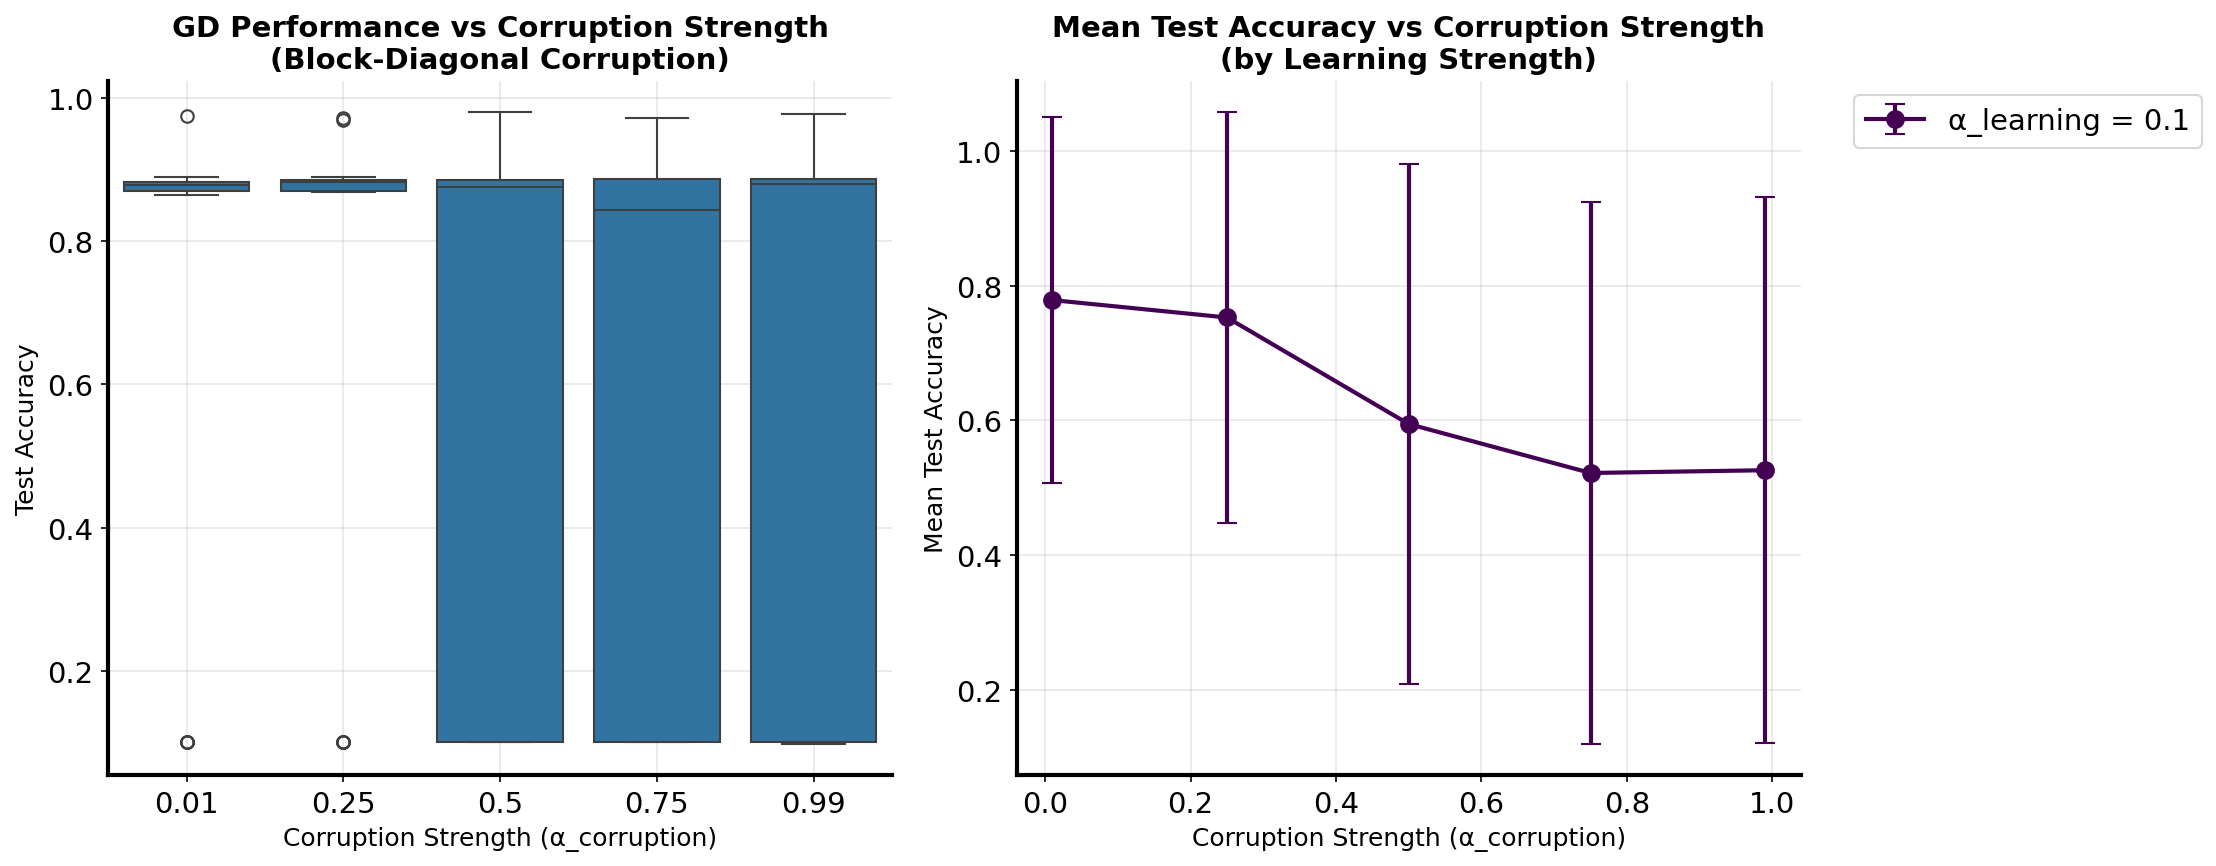

\n============================================================
SUMMARY STATISTICS: GD + Block-Diagonal Corruption
\nCorruption α = 0.01:
  Mean accuracy: 0.7785 ± 0.2713
  Range: 0.1000 - 0.9758
  Number of runs: 30
\nCorruption α = 0.25:
  Mean accuracy: 0.7527 ± 0.3041
  Range: 0.1000 - 0.9726
  Number of runs: 29
\nCorruption α = 0.5:
  Mean accuracy: 0.5946 ± 0.3850
  Range: 0.1000 - 0.9803
  Number of runs: 30
\nCorruption α = 0.75:
  Mean accuracy: 0.5220 ± 0.4013
  Range: 0.1000 - 0.9727
  Number of runs: 30
\nCorruption α = 0.99:
  Mean accuracy: 0.5261 ± 0.4046
  Range: 0.0980 - 0.9784
  Number of runs: 28


In [9]:
# Create main visualization: Test accuracy vs corruption strength for GD
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Box plot showing distribution of test accuracy for each corruption strength
sns.boxplot(data=gd_block_data, x='alpha_corruption', y='test_acc', ax=axes[0])
axes[0].set_title('GD Performance vs Corruption Strength\n(Block-Diagonal Corruption)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Corruption Strength (α_corruption)', fontsize=12)
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Mean accuracy with error bars, separated by learning strength
summary_stats = gd_block_data.groupby(['alpha_corruption', 'alpha_learning'])['test_acc'].agg(['mean', 'std', 'count']).reset_index()

# Create scatter plot with different colors for learning strengths
learning_alphas = sorted(gd_block_data['alpha_learning'].unique())
colors_learning = plt.cm.viridis(np.linspace(0, 1, len(learning_alphas)))

for i, alpha_learn in enumerate(learning_alphas):
    subset = summary_stats[summary_stats['alpha_learning'] == alpha_learn]
    axes[1].errorbar(subset['alpha_corruption'], subset['mean'], 
                    yerr=subset['std'], marker='o', label=f'α_learning = {alpha_learn}',
                    color=colors_learning[i], linewidth=2, markersize=8, capsize=5)

axes[1].set_title('Mean Test Accuracy vs Corruption Strength\n(by Learning Strength)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Corruption Strength (α_corruption)', fontsize=12)
axes[1].set_ylabel('Mean Test Accuracy', fontsize=12)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\\n" + "="*60)
print("SUMMARY STATISTICS: GD + Block-Diagonal Corruption")
print("="*60)

for alpha_corr in sorted(gd_block_data['alpha_corruption'].unique()):
    subset = gd_block_data[gd_block_data['alpha_corruption'] == alpha_corr]
    mean_acc = subset['test_acc'].mean()
    std_acc = subset['test_acc'].std()
    n_runs = len(subset)
    
    print(f"\\nCorruption α = {alpha_corr}:")
    print(f"  Mean accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"  Range: {subset['test_acc'].min():.4f} - {subset['test_acc'].max():.4f}")
    print(f"  Number of runs: {n_runs}")

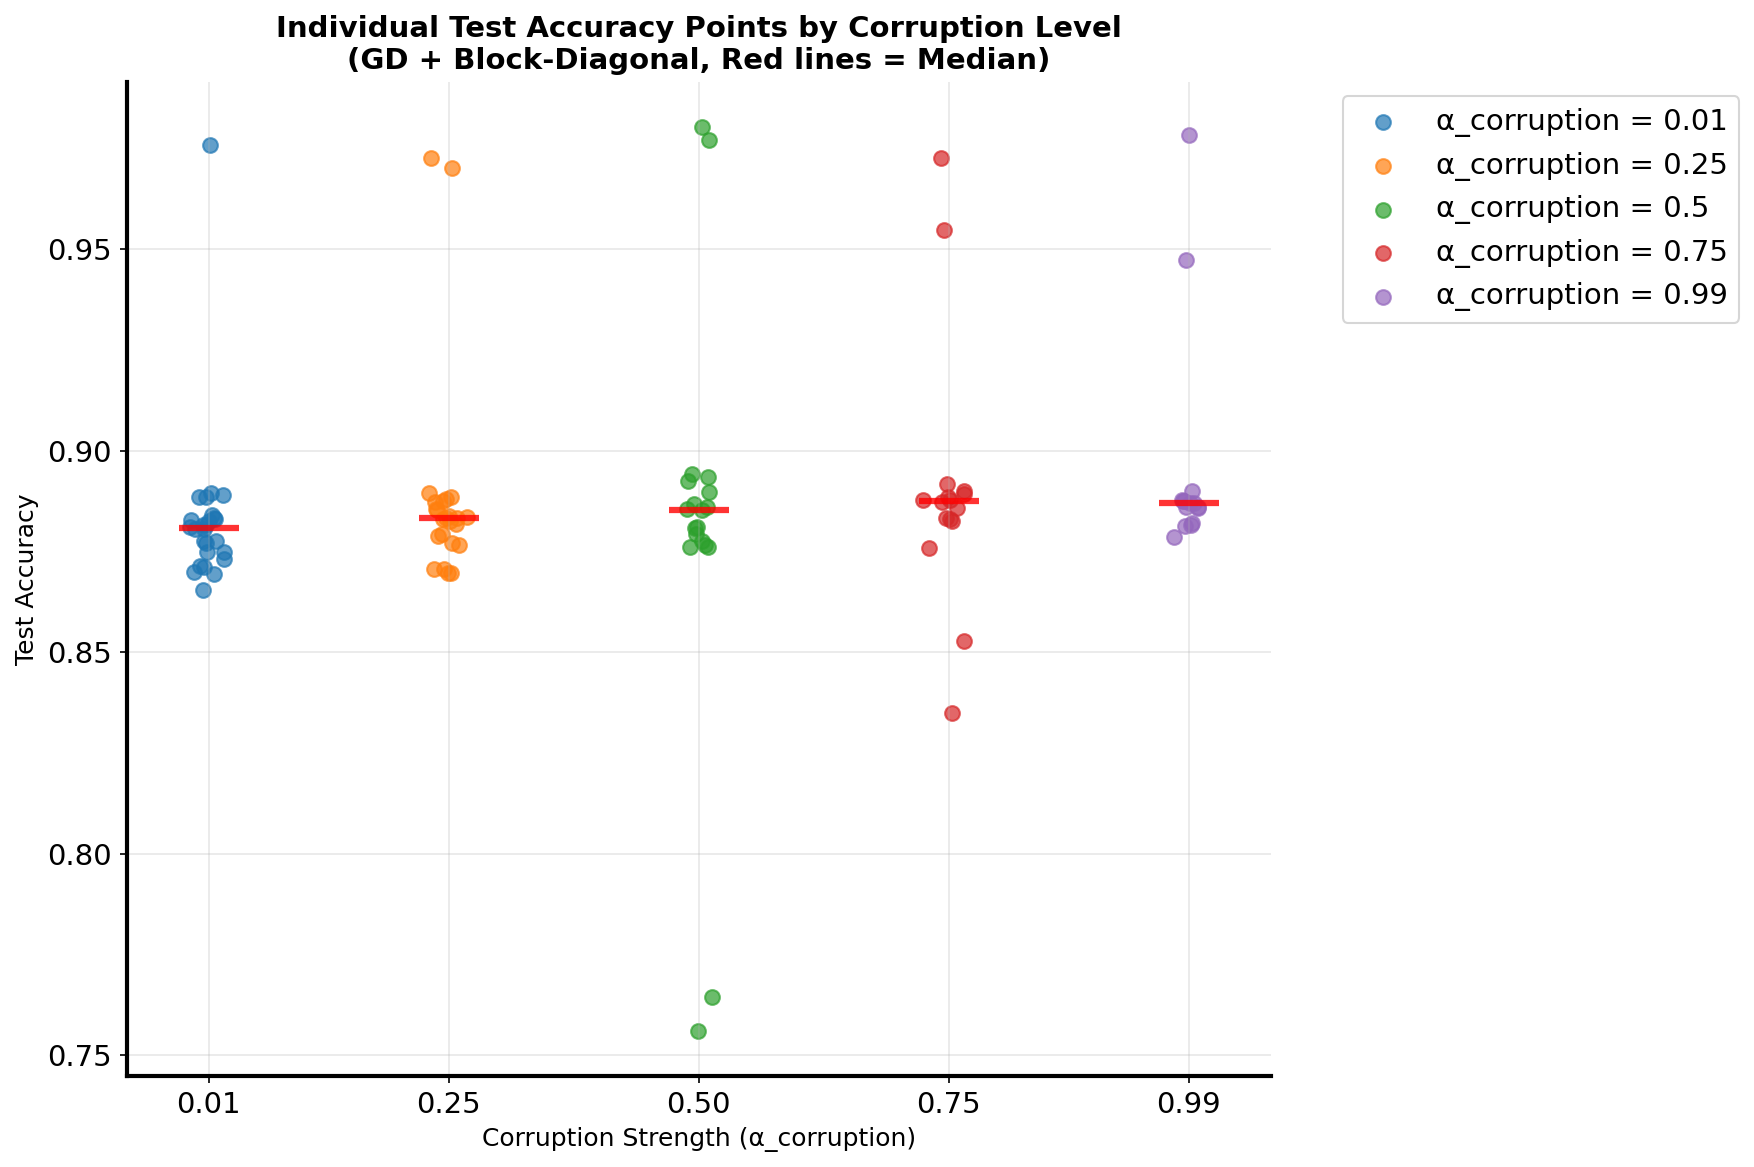

In [62]:
# Create scatter plot showing all individual data points
plt.figure(figsize=(12, 8))

gd_block_data_filtered = gd_block_data[gd_block_data['test_acc'] >= 0.2].copy()

# Add some jitter to x-axis to see overlapping points
np.random.seed(42)  # For reproducible jitter
corruption_levels = sorted(gd_block_data_filtered['alpha_corruption'].unique())

for i, alpha_corr in enumerate(corruption_levels):
    subset = gd_block_data_filtered[gd_block_data_filtered['alpha_corruption'] == alpha_corr]

    # Add small random jitter to x-coordinates to spread out overlapping points
    x_jitter = np.random.normal(alpha_corr, 0.01, len(subset))

    plt.scatter(x_jitter, subset['test_acc'], alpha=0.7, s=50, label=f'α_corruption = {alpha_corr}')

# Add median line for each corruption level
medians = gd_block_data_filtered.groupby('alpha_corruption')['test_acc'].median()
for alpha_corr, median_val in medians.items():
    plt.hlines(median_val, alpha_corr - 0.03, alpha_corr + 0.03, colors='red', linewidth=3, alpha=0.8)

plt.xlabel('Corruption Strength (α_corruption)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Individual Test Accuracy Points by Corruption Level\n(GD + Block-Diagonal, Red lines = Median)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x-axis to show exact corruption values
plt.xticks(corruption_levels)

plt.tight_layout()
plt.show()

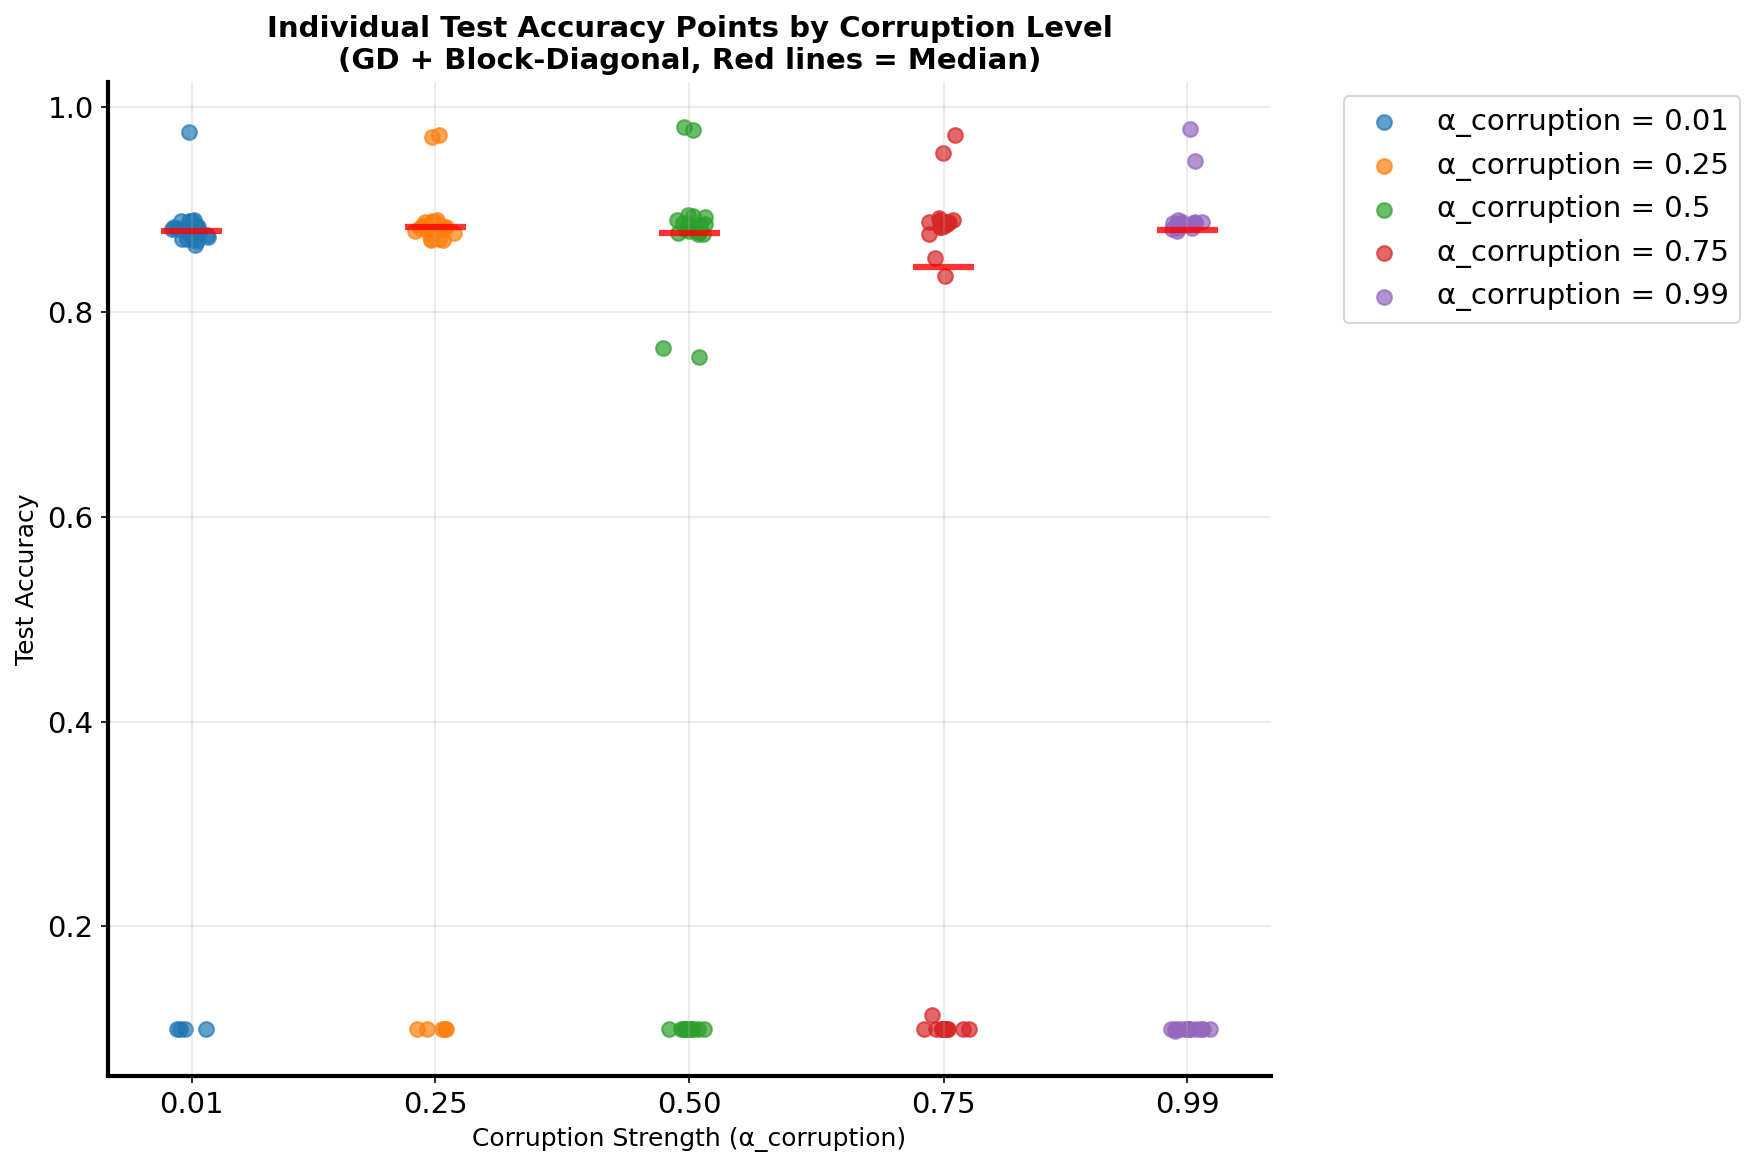

In [63]:
# Create scatter plot showing all individual data points
plt.figure(figsize=(12, 8))

gd_block_data_filtered = gd_block_data.copy()

# Add some jitter to x-axis to see overlapping points
np.random.seed(42)  # For reproducible jitter
corruption_levels = sorted(gd_block_data_filtered['alpha_corruption'].unique())

for i, alpha_corr in enumerate(corruption_levels):
    subset = gd_block_data_filtered[gd_block_data_filtered['alpha_corruption'] == alpha_corr]

    # Add small random jitter to x-coordinates to spread out overlapping points
    x_jitter = np.random.normal(alpha_corr, 0.01, len(subset))

    plt.scatter(x_jitter, subset['test_acc'], alpha=0.7, s=50, label=f'α_corruption = {alpha_corr}')

# Add median line for each corruption level
medians = gd_block_data_filtered.groupby('alpha_corruption')['test_acc'].median()
for alpha_corr, median_val in medians.items():
    plt.hlines(median_val, alpha_corr - 0.03, alpha_corr + 0.03, colors='red', linewidth=3, alpha=0.8)

plt.xlabel('Corruption Strength (α_corruption)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Individual Test Accuracy Points by Corruption Level\n(GD + Block-Diagonal, Red lines = Median)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Set x-axis to show exact corruption values
plt.xticks(corruption_levels)

plt.tight_layout()
plt.show()